Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular,Decorrelation, DecorConv2dOrig # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
import matplotlib.pyplot as plt

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
def decorrelate(num_epochs, data, model, lr=1e-2):

    # covariance matrix before training
    X = model.forward(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    D = np.zeros(num_epochs)
    V = np.zeros(num_epochs)
    for i in range(num_epochs):
        y = model.forward(data)
        D[i], V[i] = model.update()
        model.R -= lr * model.R.grad
        print(f'iteration {i}\ttotal loss: {D[i] + V[i]:.3f}')

    # covariance matrix after training
    X = model.forward(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return D, V, A1, A2

We start by showing effective decorrelation of correlated input

iteration 0	total loss: 0.140
iteration 1	total loss: 0.139
iteration 2	total loss: 0.138
iteration 3	total loss: 0.137
iteration 4	total loss: 0.136
iteration 5	total loss: 0.135
iteration 6	total loss: 0.134
iteration 7	total loss: 0.133
iteration 8	total loss: 0.132
iteration 9	total loss: 0.131
iteration 10	total loss: 0.130
iteration 11	total loss: 0.129
iteration 12	total loss: 0.128
iteration 13	total loss: 0.127
iteration 14	total loss: 0.126
iteration 15	total loss: 0.126
iteration 16	total loss: 0.125
iteration 17	total loss: 0.124
iteration 18	total loss: 0.123
iteration 19	total loss: 0.122
iteration 20	total loss: 0.121
iteration 21	total loss: 0.120
iteration 22	total loss: 0.120
iteration 23	total loss: 0.119
iteration 24	total loss: 0.118
iteration 25	total loss: 0.117
iteration 26	total loss: 0.117
iteration 27	total loss: 0.116
iteration 28	total loss: 0.115
iteration 29	total loss: 0.114
iteration 30	total loss: 0.114
iteration 31	total loss: 0.113
iteration 32	total

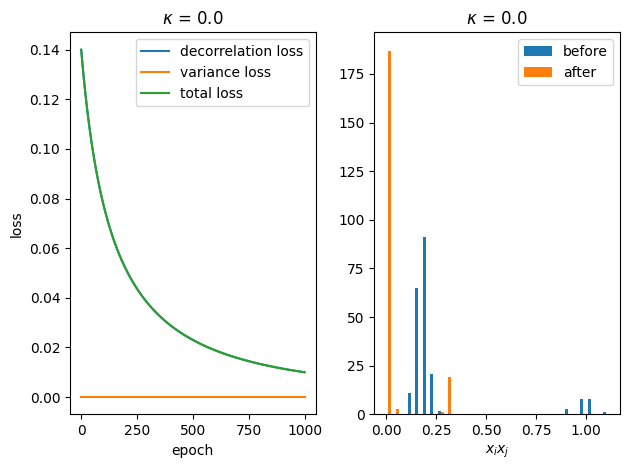

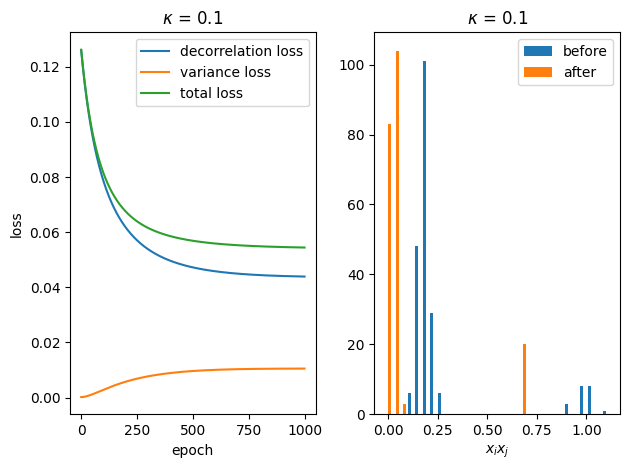

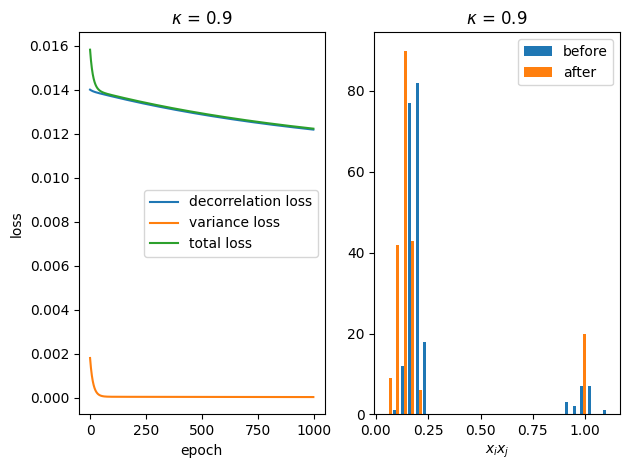

In [3]:
num_samples=1000
num_features=20
num_epochs=1000
kappas = [0.0, 0.1, 0.9]
lr=1e-1
seed=42

for kappa in kappas:

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    # generate correlated data
    d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
    data = d.sample((num_samples,))

    # create a decorrelator
    model = Decorrelation(size=num_features, kappa=kappa)

    D, V, A1, A2 = decorrelate(num_epochs, data, model, lr=lr) 

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(D, label='decorrelation loss')
    plt.plot(V, label='variance loss')
    plt.plot(D+V, label='total loss')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(f'$\kappa$ = {kappa}')
    plt.subplot(1,2,2)
    plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
    plt.legend()
    plt.xlabel('$x_i x_j$')
    plt.title(f'$\kappa$ = {kappa}')
    plt.legend();
    plt.tight_layout()

Decorrelation of correlated input using DecorConv2d

In [4]:
def decorrelate(num_epochs, data, model, lr=1e-2):
    # specifically for current conv2d implementation

    # # covariance matrix before training
    # # NOT CORRECT. REQUIRES PATCHES!!!
    # X = model.forward(data).view(data.shape[0],-1)
    # A1 = (X.T @ X) / len(X)
    A1 = None

    # train decorrelator
    D = np.zeros(num_epochs)
    V = np.zeros(num_epochs)
    for i in range(num_epochs):
        y = model.forward(data)
        D[i], V[i] = model.update()
        model.weight -= lr * model.weight.grad
        print(f'iteration {i}\ttotal loss: {D[i] + V[i]:.3f}')

    # # covariance matrix after training
    # X = model.forward(data).view(data.shape[0],-1)
    # A2 = (X.T @ X) / len(X)
    A2 = None

    return D, V, A1, A2

iteration 0	total loss: 0.833
iteration 1	total loss: 0.087
iteration 2	total loss: 0.041
iteration 3	total loss: 0.029
iteration 4	total loss: 0.015
iteration 5	total loss: 0.014
iteration 6	total loss: 0.010
iteration 7	total loss: 0.008
iteration 8	total loss: 0.007
iteration 9	total loss: 0.006
iteration 10	total loss: 0.005
iteration 11	total loss: 0.005
iteration 12	total loss: 0.004
iteration 13	total loss: 0.005
iteration 14	total loss: 0.003
iteration 15	total loss: 0.002
iteration 16	total loss: 0.002
iteration 17	total loss: 0.002
iteration 18	total loss: 0.002
iteration 19	total loss: 0.002


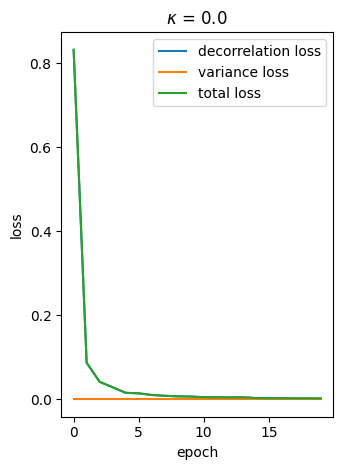

In [17]:
# generate [N, M] correlated input
num_examples=1000
in_channels=2
out_channels=3
height=20
width=20
num_features=in_channels*height*width
kernel_size=(5,5)
num_samples=1000
num_epochs=20
# kappas = [0.0, 0.1, 0.25, 0.5]
kappas = [0.0]
lr=1e-2
seed=42

for kappa in kappas:

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
    data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width)

    # create a convolutional decorrelator
    model = DecorConv2dOrig(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, kappa=kappa)

    D, V, A1, A2 = decorrelate(num_epochs, data, model, lr=lr) 

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(D, label='decorrelation loss')
    plt.plot(V, label='variance loss')
    plt.plot(D+V, label='total loss')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(f'$\kappa$ = {kappa}')
    # plt.subplot(1,2,2)
    # plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
    # plt.legend()
    # plt.xlabel('$x_i x_j$')
    # plt.title(f'$\kappa$ = {kappa}')
    # plt.legend();
    plt.tight_layout()

In [12]:
# L = torch.tril(torch.randn(5,5), diagonal=-1)
# print(L)
# print(torch.sum(torch.square(L)))
# print(torch.trace(L @ L.T))


tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.6319,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0759, -0.3913,  0.0000,  0.0000,  0.0000],
        [-1.2944, -0.0527,  0.1203,  0.0000,  0.0000],
        [-0.4993, -0.0245, -0.7109, -0.9134,  0.0000]])
tensor(3.8405)
tensor(3.8405)


In [6]:
# Note: We report a different loss (I think...)

To do:
- experiment can be used if current approach works. Do we have any guarantee of decorrelated input if average over patches? and if we take only center pixel? We can check by extracting the patches for the created output again and compute covariances
- reimplement code sander as starting point also for comparison